
GB Accuracy
Train: 0.8328
Val  : 0.8812
Test : 0.8550

GB Log Loss
Train: 0.4836
Val  : 0.4662
Test : 0.4855


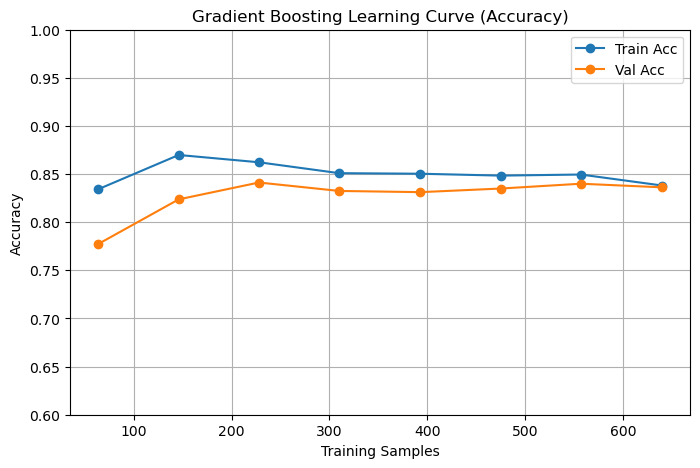

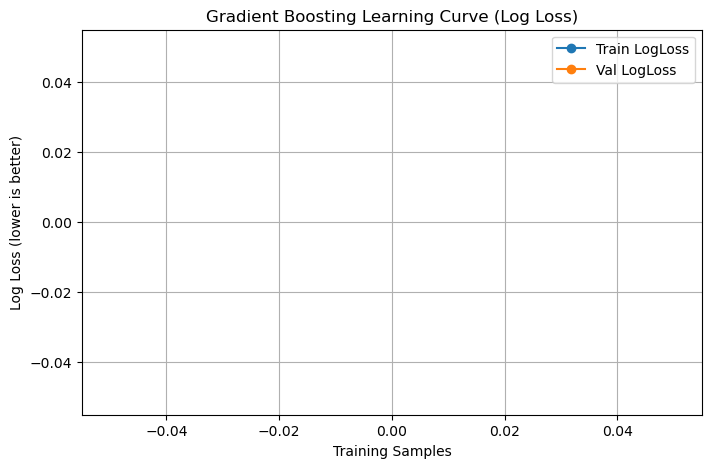

In [8]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, make_scorer

# -------------------
# Load CSV
# -------------------
DATA_PATH = r"C:\Users\msi\Desktop\Model Training\KOA_Dataset_optionA.csv"
TARGET = "KOA"

df = pd.read_csv(DATA_PATH)
df = df.drop(columns=["Timestamp", "Column 1", "Patient Identification Number"], errors="ignore")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

X = df.drop(columns=[TARGET], errors="ignore")
y = df[TARGET]

# Encode target if text
if y.dtype == "object":
    y = y.astype("category").cat.codes
else:
    y = y.astype(int)

# -------------------
# Columns
# -------------------
num_cols = X.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# -------------------
# Preprocess (WITH IMPUTER ✅)
# -------------------
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # ✅ FIX NaNs
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # ✅ FIX NaNs
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

# -------------------
# Split
# -------------------
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.20, stratify=y_trainval, random_state=42
)

# -------------------
# Model
# -------------------
gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=1,            # ✅ reduce complexity a lot
    subsample=0.50,         # ✅ more randomness
    min_samples_split=20,   # ✅ prevent tiny splits
    min_samples_leaf=15,    # ✅ smoother trees
    random_state=42
)


pipe = Pipeline([("preprocess", preprocess), ("model", gb)])
pipe.fit(X_train, y_train)

# -------------------
# Metrics: Accuracy + LogLoss
# -------------------
train_acc = accuracy_score(y_train, pipe.predict(X_train))
val_acc   = accuracy_score(y_val, pipe.predict(X_val))
test_acc  = accuracy_score(y_test, pipe.predict(X_test))

train_loss = log_loss(y_train, pipe.predict_proba(X_train))
val_loss   = log_loss(y_val, pipe.predict_proba(X_val))
test_loss  = log_loss(y_test, pipe.predict_proba(X_test))

print("\nGB Accuracy")
print(f"Train: {train_acc:.4f}")
print(f"Val  : {val_acc:.4f}")
print(f"Test : {test_acc:.4f}")

print("\nGB Log Loss")
print(f"Train: {train_loss:.4f}")
print(f"Val  : {val_loss:.4f}")
print(f"Test : {test_loss:.4f}")

# -------------------
# Learning Curves (Accuracy + LogLoss)
# -------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_sizes = np.linspace(0.1, 1.0, 8)

# Accuracy curve
sizes, tr_acc_scores, va_acc_scores = learning_curve(
    pipe, X_trainval, y_trainval,
    train_sizes=train_sizes,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

plt.figure(figsize=(8,5))
plt.plot(sizes, tr_acc_scores.mean(axis=1), marker="o", label="Train Acc")
plt.plot(sizes, va_acc_scores.mean(axis=1), marker="o", label="Val Acc")
plt.title("Gradient Boosting Learning Curve (Accuracy)")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.ylim(0.60, 1.0)
plt.grid(True)
plt.legend()
plt.show()

# Log-loss curve (negative scorer -> convert back)
def neg_ll(estimator, Xb, yb):
    return -log_loss(yb, estimator.predict_proba(Xb))

ll_scorer = make_scorer(neg_ll, greater_is_better=True)

sizes, tr_ll_scores, va_ll_scores = learning_curve(
    pipe, X_trainval, y_trainval,
    train_sizes=train_sizes,
    cv=cv,
    scoring=ll_scorer,
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

plt.figure(figsize=(8,5))
plt.plot(sizes, (-tr_ll_scores).mean(axis=1), marker="o", label="Train LogLoss")
plt.plot(sizes, (-va_ll_scores).mean(axis=1), marker="o", label="Val LogLoss")
plt.title("Gradient Boosting Learning Curve (Log Loss)")
plt.xlabel("Training Samples")
plt.ylabel("Log Loss (lower is better)")
plt.grid(True)
plt.legend()
plt.show()
